# Demo EDM on a single pair of images

In [1]:
import torch
import cv2
import matplotlib.cm as cm
from src.utils.plotting import make_matching_figure

## Indoor Example

In [2]:
from src.edm import EDM
from src.config.default import get_cfg_defaults
from src.utils.misc import lower_config
from src.edm import EDM

config = get_cfg_defaults()
data_cfg_path = "configs/data/scannet_test_1500.py"
main_cfg_path = "configs/edm/indoor/edm_base.py"
config.merge_from_file(main_cfg_path)
config.merge_from_file(data_cfg_path)

W, H = 640, 480
config.EDM.COARSE.MCONF_THR = 0.2
config.EDM.COARSE.BORDER_RM = 2

_config = lower_config(config)
matcher = EDM(config=_config["edm"]).cuda()
state_dict = torch.load("weights/edm_outdoor.ckpt")["state_dict"]
matcher.load_state_dict(state_dict)
matcher = matcher.eval().cuda()

In [ ]:
# Load example images
img0_pth = "assets/scannet_sample_images/scene0707_00_15.jpg"
img1_pth = "assets/scannet_sample_images/scene0707_00_45.jpg"
img0_bgr = cv2.imread(img0_pth)
img1_bgr = cv2.imread(img1_pth)

# For draw
img0_rgb = img0_bgr[:, :, ::-1]
img1_rgb = img1_bgr[:, :, ::-1]
img0_rgb = cv2.resize(img0_rgb, (W, H))
img1_rgb = cv2.resize(img1_rgb, (W, H))

# For inference
img0_raw = cv2.cvtColor(img0_bgr, cv2.COLOR_BGR2GRAY)
img1_raw = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2GRAY)
img0_raw = cv2.resize(img0_raw, (W, H))
img1_raw = cv2.resize(img1_raw, (W, H))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with EDM and get prediction
with torch.no_grad():
    matcher(batch)

mkpts0 = batch['mkpts0_f'].cpu().numpy()
mkpts1 = batch['mkpts1_f'].cpu().numpy()
mconf = batch['mconf'].cpu().numpy()

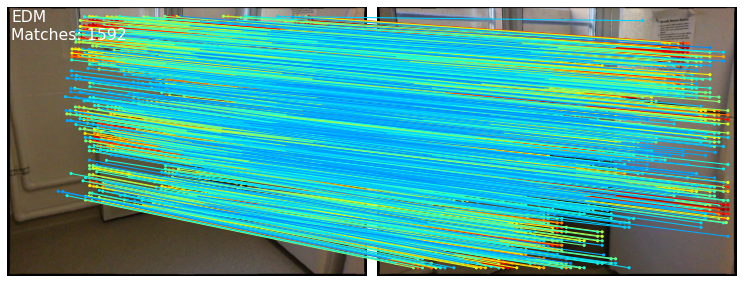

In [4]:
# Draw
color = cm.jet(mconf)
text = [
    'EDM',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_rgb, img1_rgb, mkpts0, mkpts1, color, text=text)

## Outdoor Example

In [5]:
from src.edm import EDM
from src.config.default import get_cfg_defaults
from src.utils.misc import lower_config

config = get_cfg_defaults()
data_cfg_path = "configs/data/megadepth_test_1500.py"
main_cfg_path = "configs/edm/outdoor/edm_base.py"
config.merge_from_file(main_cfg_path)
config.merge_from_file(data_cfg_path)

W, H = 832, 832
config.EDM.COARSE.MCONF_THR = 0.2
config.EDM.COARSE.BORDER_RM = 2
config.EDM.TEST_RES_H = H
config.EDM.TEST_RES_W = W

_config = lower_config(config)
matcher_out = EDM(config=_config['edm']).cuda()
state_dict = torch.load("weights/edm_outdoor.ckpt")["state_dict"]
matcher_out.load_state_dict(state_dict)
matcher_out = matcher_out.eval().cuda()

In [6]:
# Load example images
img0_pth = "assets/phototourism_sample_images/united_states_capitol_26757027_6717084061.jpg"
img1_pth = "assets/phototourism_sample_images/united_states_capitol_98169888_3347710852.jpg"

img0_bgr = cv2.imread(img0_pth)
img1_bgr = cv2.imread(img1_pth)

# For draw
img0_rgb = img0_bgr[:, :, ::-1]
img1_rgb = img1_bgr[:, :, ::-1]
img0_rgb = cv2.resize(img0_rgb, (W, H))
img1_rgb = cv2.resize(img1_rgb, (W, H))

# For inference
img0_raw = cv2.cvtColor(img0_bgr, cv2.COLOR_BGR2GRAY)
img1_raw = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2GRAY)
img0_raw = cv2.resize(img0_raw, (W, H))  # input size shuold be divisible by 32
img1_raw = cv2.resize(img1_raw, (W, H))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with EDM and get prediction
with torch.no_grad():
    matcher_out(batch)

mkpts0 = batch['mkpts0_f'].cpu().numpy()
mkpts1 = batch['mkpts1_f'].cpu().numpy()
mconf = batch['mconf'].cpu().numpy()

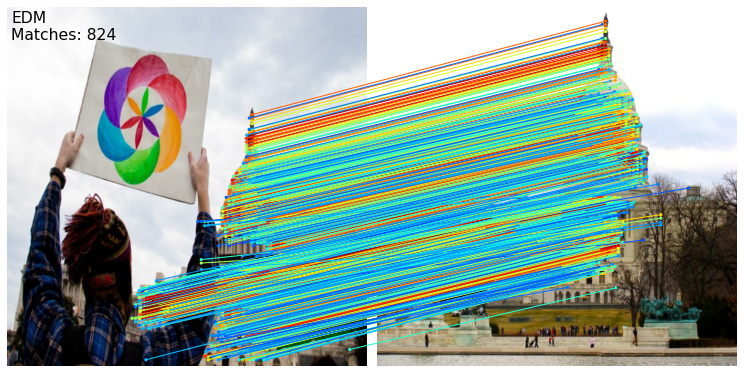

In [7]:
# Draw
color = cm.jet(mconf)
text = [
    'EDM',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_rgb, img1_rgb, mkpts0, mkpts1, color, text=text)